# Time evolution of a state under the full swapping Hamiltonian with collisions included

The state being stored is given by:

$$
|\psi\rangle = |1\rangle
$$


One dimensionality satisfied
RHS is greater then LHS by, 11.816 times
drive power =  8.584293215184512e-10
eta_l and eta_p :  450.0547675537846 4.500547675537846
omega_c =  172.268
omega_d =  126.564
omega_c-omega_d =  45.704
g_prime/gamma_0 =  0.053
number of thermal photons in atomic modes c and d:  2.963996425317431e-180 1.264118188079506e-132


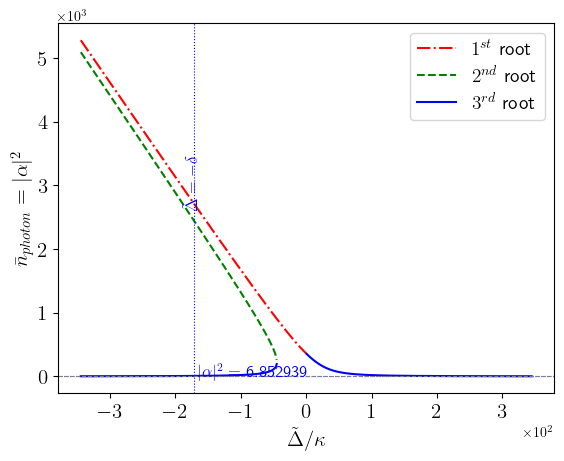

photon number at (delta_tilde = -small_delta) is 6.866789
Q_cs = -0.08776534651866302 and Q_ds = -0.1194450030196379
|alpha_s|^2 (photon number) =  6.853
G_tilde =  4.08
Criterion satisfied
ratio of RHS by LHS:  3.086464385691955
LHS 1898.0997665922864
K.E 5522.4173300773045
Coll 336.0000000000001
scattering rate less than 1
scattering rate 5.768559671149552e-06
Real part of the eigenvalues of the Jacobian matrix are: [-0.24721298 -0.24708444 -0.00562817 -0.2446426  -0.24980958 -0.00563889]
Eigen values with positive real part []
The system is stable.


In [1]:
%run ./bistability_plot.ipynb

#### Storage and retrieval of a quantum state in a four mode optomechanical system

#### Hamiltonian

$$
\frac{\hat{H}_{bare}}{\hbar} = -\hat{a}^\dagger\hat{a}\tilde{\Delta} + \omega_c\hat{c}^\dagger\hat{c} + \omega_d\hat{d}^\dagger\hat{d}
$$

$$
\frac{\hat{H}_{int}}{\hbar} = -\tilde{G}\left(\hat{a}^\dagger\hat{c} + \hat{a}\hat{c}^\dagger \right) - \tilde{G}\left(\hat{a}^\dagger\hat{d} + \hat{a}\hat{d}^\dagger \right)
$$

$$
\frac{\hat{H}_{coll}}{\hbar} = 2g^\prime \left( \hat{c}^\dagger \hat{c} + \hat{d}^\dagger \hat{d} \right)
+ g^\prime \left( \hat{c} \hat{d} e^{-i 2\delta t} + \hat{c}^\dagger \hat{d}^\dagger e^{i2\delta t} \right)
$$


Here, $\tilde{G}$ is the boosted coupling constant, and $g^\prime = 2\tilde{g}N$

#### Libraries

In [2]:
import numpy as np
from qutip import *

#### Parameters

In [3]:
# Define constants
g       = g_prime

omega_c = np.round(omega_c, 3)
omega_d = np.round(omega_d, 3)

delta   = omega_c + 4*g_tilde*Na     # small delta = omega_p - omega_l 

Delta   = -delta
boost_coup_const = np.round(np.abs(G_tilde_val), 3)
nth_c   = np.round(nth_c,4)
nth_d   = np.round(nth_c,4)


#### All function definitions

In [4]:
def thermal_state(n_th, dim):
    """Generate a thermal state with mean phonon number n_th."""
    return thermal_dm(dim, n_th)

# Time-dependent functions
def switch_function(t, t_start, t_off, off_duration, smoothness):
    """
    Defines a smooth function that switches on and off based on given parameters.

    arguments:
    t: Time at which the function is evaluated.
    t_on: The time at which the function switches on.
    t_off: The time at which the function switches off.
    offduration: The duration for which the function stays off.
    smoothness: Controls how smoothly the function switches off and on.

    Returns:
    The value of the function at time t.
    """
    def switching_on(t_on):
        return 0.5 * (1 + np.tanh(smoothness * (t - t_on)))
    
    def switching_off(t_off):
        return 0.5 * (1 - np.tanh(smoothness * (t - t_off)))

    return switching_on(t_start)*switching_off(t_off) + switching_on(t_off + off_duration)

def Gt(t, args):
    """ args is a dictionary containing a list of parameters
    """
    t_start = args['t_start']
    t_off   = args['t_off']
    off_duration = args['off_duration']
    smoothness   = args['smoothness']
    global boost_coup_const, switch_function
    return boost_coup_const*switch_function(t, t_start, t_off, off_duration, smoothness)

# Time-dependent coefficients
def f_20(t, args):
    delta = args['delta']
    return np.exp(-1j * delta* t)

def f_21(t, args):
    delta = args['delta']
    return np.exp(1j * delta * t)


#### Define the Hilbert space and Hamiltonian

In [5]:
# Define annihilation operators for each mode
N1 = 5  # Truncation level for Fock space
N2 = 5

# Modes a1, a2, c, d
a  = destroy(N1)
c  = destroy(N2)
d  = destroy(N2)

# Create the Hilbert space by tensoring the operators
a_op = tensor(a, qeye(N1), qeye(N2))
c_op  = tensor(qeye(N1), c, qeye(N2))
d_op  = tensor(qeye(N1), qeye(N2), d)

# Number operators in composite space
n_a_op = a_op.dag() * a_op
n_c_op = c_op.dag() * c_op
n_d_op = d_op.dag() * d_op

# Define the Hamiltonian components
# Bare Hamiltonian
H_00 = -n_a_op * Delta + n_c_op * omega_c + n_d_op * omega_d

# beam splitter part
H_10 = -(a_op.dag() * c_op + a_op * c_op.dag())
H_11 = -(a_op.dag() * d_op + a_op * d_op.dag())

# Collisional part
H_20 = g*c_op*d_op
H_21 = g*c_op.dag()*d_op.dag()
H_22 = 2 * g * (n_c_op + n_d_op)

# Full Hamiltonian 
H = [H_00,                                     # here, [H_10, Gt] means H_10*Gt and [H_00, [H_10, Gt]] means H_00 + H_10*Gt.
    [H_10, Gt],[H_11, Gt],
    [H_20, f_20],[H_21, f_21],
    H_22
]

#Beam splitter Hamiltonian
H = [
    [H_10, Gt]
]

# Collapse operators
c_ops = [np.sqrt(kappa) * a_op,             # Optical loss mode a
    np.sqrt(gamma_m * (nth_c + 1)) * c_op,  # rate at which phonons are removed from the system
    np.sqrt(gamma_m * nth_c) * c_op.dag(),  # rate at which phonons are added to the system
    np.sqrt(gamma_m * (nth_d + 1)) * d_op,
    np.sqrt(gamma_m * nth_d) * d_op.dag()
]

#### Intialization

Define the density matrix of the composite system at time, $t = 0$

In [6]:
# Initial state
optical_state = fock_dm(N1, 1)
mech_state    = tensor(thermal_state(nth_c, N2), thermal_state(nth_d, N2))
initial_state = tensor(optical_state, mech_state)


#### Define all time related parameters

In [7]:
# Time range and parameters
period = np.pi / (2 * boost_coup_const)

t_start      = -100
t_off        = period
off_duration = 10*period
t_on         = t_off + off_duration # np.round(t_off + off_duration,1)
smoothness   = 80                   # this parameter determins how smoothly the drive field is switched off and then back on, decreasing its value leads to increase in smoothness

t_write      = t_off                #np.round(t_off,1)
t_read       = t_on + period        #np.round(t_on + period,1)

t_total = t_on + 5*period
t_eval = (0, t_total)
dt     = 0.01
nt     = int(t_eval[1]/dt)
time_points = np.linspace(t_eval[0],t_eval[1] , nt)

#### Solution of Master Equation

In [8]:

# Dictionary for storing arguments
args_dic = {'t_start': t_start, 't_off': t_off, 'off_duration': off_duration, 'smoothness': smoothness, 'delta': delta}

# Dictionary for storing options
options_dic = {"progress_bar": True, "store_states": True, "atol":1e-5, "rtol": 1e-4, "nsteps":800}

# e_ops list
e_ops_list = [n_a_op, n_c_op, n_d_op, a_op, c_op, d_op]

# solve using qutip.mesolve()
result = mesolve(H, initial_state, time_points, c_ops = c_ops, e_ops= e_ops_list, args = args_dic, options = options_dic)  # in "e_ops" ops stands for operators, "e" stands for expectation

10.1%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.1%. Run time:   0.10s. Est. time left: 00:00:00:00
40.1%. Run time:   0.12s. Est. time left: 00:00:00:00
50.0%. Run time:   0.14s. Est. time left: 00:00:00:00
60.1%. Run time:   0.16s. Est. time left: 00:00:00:00
70.0%. Run time:   0.20s. Est. time left: 00:00:00:00
80.1%. Run time:   0.26s. Est. time left: 00:00:00:00
90.1%. Run time:   0.31s. Est. time left: 00:00:00:00
100.0%. Run time:   0.35s. Est. time left: 00:00:00:00
Total run time:   0.35s


20.0%. Run time:   0.16s. Est. time left: 00:00:00:00
30.1%. Run time:   0.19s. Est. time left: 00:00:00:00
40.1%. Run time:   0.21s. Est. time left: 00:00:00:00
50.0%. Run time:   0.25s. Est. time left: 00:00:00:00
60.1%. Run time:   0.28s. Est. time left: 00:00:00:00
70.0%. Run time:   0.34s. Est. time left: 00:00:00:00
80.1%. Run time:   0.41s. Est. time left: 00:00:00:00
90.1%. Run time:   0.47s. Est. time left: 00:00:00:00
100.0%. Run time:   0.53s. Est. time left: 00:00:00:00
Total run time:   0.53s


# Plots

#### Configure matplotlib

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# enable TeX fonts
plt.rcParams['text.usetex'] = True

# Set the global font size for all legends
mpl.rcParams['legend.fontsize'] = 14

# Set the global font size for all axis labels
mpl.rcParams['axes.labelsize'] = 14

# Set the global font style for all axis labels
plt.rcParams['font.family'] = 'Times New Roman'


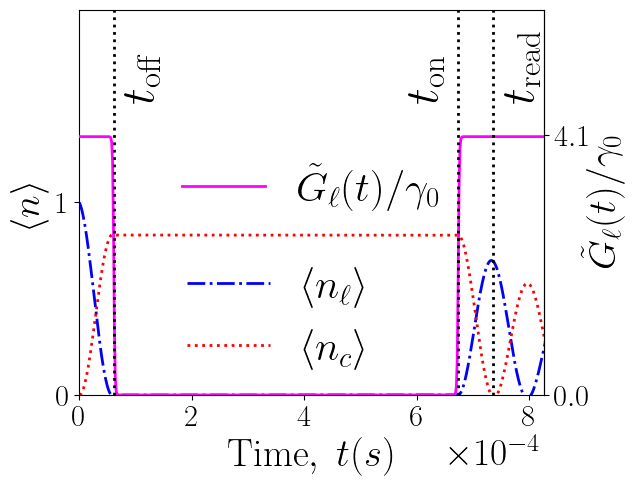

In [10]:
# Plot expectation values
fig, ax1 = plt.subplots(figsize=(6, 5)) #facecolor='#E5ECF6')

# define a secondary y-axis
ax2 = ax1.twinx() 

# customize plot border
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

 
# plots
####################################################

# drive field
ax2.plot(time_points/kappa_0, Gt(time_points, args_dic), label=r"$\tilde{G}_\ell(t)/\gamma_0$", linestyle='-', linewidth=2, color = 'magenta')

# optical
ax1.plot(time_points/kappa_0, result.expect[0], linestyle='-.', label=r"$\langle n_\ell\rangle$", color = 'b', linewidth=2)

# BEC modes
ax1.plot(time_points/kappa_0, result.expect[1], linestyle=':', label=r"$\langle n_{c}\rangle$", color = 'r', linewidth=2)
#ax1.plot(time_points/kappa_0, result.expect[2], linestyle='-', label=r"$\langle \hat{n}_{d}\rangle$", color = 'g')

# axis labels
ax1.set_xlabel(r'$\mathrm{Time},\; t(s)$', fontsize = 28)
ax1.set_ylabel(r'$\langle n\rangle$', fontsize = 28, labelpad=5)
ax2.set_ylabel(r'$\tilde{G}_\ell(t)/\gamma_0$', fontsize = 28, labelpad=-7)

# axis range
ax1.set_xlim(0,(t_read + period + period/2 )/kappa_0)
ax1.set_ylim(0, 2)
ax2.set_ylim(0, boost_coup_const + 2)


# axis ticks
ax1.tick_params(axis='both', labelsize=22)
ax2.tick_params(axis='both', labelsize=22)
ax1.set_yticks([0,  1], minor=False)
ax2.set_yticks([0,  np.round(boost_coup_const,1)], minor=False)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(1,2))
ax1.xaxis.offsetText.set_fontsize(27)

# legends
ax1.legend(fontsize = 30, bbox_to_anchor=(0.15, 0.2), facecolor='none', frameon=False) # loc='upper left', 
ax2.legend(fontsize = 30, bbox_to_anchor=(0.5, 0.7), facecolor='none', frameon=False)

# Vertical lines
# Plot a vertical line at t = T_period
plt.axvline(x= period/kappa_0, color='black', linestyle=':', linewidth = 2)

# Plot a vertical line at t = T_on = off_duration + T_period
plt.axvline(x= t_on/kappa_0, color='black', linestyle=':', linewidth = 2)

# Plot a vertical line at t = T_on + T_period = off_duration + 2*T_period
plt.axvline(x= t_read/kappa_0, color='black', linestyle=':', linewidth = 2)

# Add texts
y_min, y_max = ax2.get_ylim()      # Get the limits of the y-axis
y_center = (y_min + y_max)/ 2      # Calculate the center of the y-axis

plt.text((t_off + 7*dt)/kappa_0, y_center + 1.7, r'$t\textsubscript{off}$', rotation=90, color='black', fontsize = '34')
plt.text((t_on - 60*dt)/kappa_0, y_center + 1.7, r'$t\textsubscript{on}$', rotation=90, color='black', fontsize = '34')
plt.text((t_read + 8*dt)/kappa_0, y_center + 1.7, r'$t\textsubscript{read}$', rotation=90, color='black', fontsize = '34')

# Margins
plt.margins(0)  # no horizontal or vertical padding

# Make figure background transparent
fig.patch.set_alpha(0.0)

# save the plot to a file
filename = 'figure1iii.svg'
plt.savefig(filename, format='svg', dpi=32,transparent=True)

plt.show()


#### Retrieval fidelity

In [12]:
options_dic = {"progress_bar": True, "store_states": True, "nsteps":20e3}

# solve using qutip.mesolve()
result = mesolve(H, initial_state, [0, t_read], c_ops = c_ops, e_ops= None, args = args_dic, options = options_dic)

# evaluate the retrieved density matrix
rho_opt_read  = result.states[0].ptrace([0])

fidelity_val = fidelity(optical_state, rho_opt_read)  # Fidelity between optical state at t = 0 and t = t_read
print("Retrieval fidelity = ", np.round(fidelity_val, 3)*100, "%")


100.0%. Run time:   0.15s. Est. time left: 00:00:00:00
Total run time:   0.15s
Retrieval fidelity =  100.0 %
